# 1. 라이브러리 import

In [1]:
import os
from os.path import join

import numpy as np
import pandas as pd
from pandas import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import xgboost
import lightgbm
import missingno as msno
import sklearn

print(xgboost.__version__)
print(lightgbm.__version__)
print(msno.__version__)
print(sklearn.__version__)

1.4.2
3.3.0
0.5.0
1.0


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(


# 2. 데이터 가져오기

- train: 캐글에서 제공한 학습을 위한 데이터
- test: 캐글에 제출 목적으로 predict를 위한 데이터

In [3]:
data_dir = os.getenv('HOME')+"/aiffel/kaggle_kakr_housing/data/"

train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')      # 테스트, 즉 submission 시 사용할 데이터 경로

In [4]:
train_original = pd.read_csv(train_data_path)
test_original = pd.read_csv(test_data_path)

여러 실험을 위해 train_original, test_original로 원본데이터를 백업해둔다

In [5]:
train = train_original.copy()
test = test_original.copy()

# 3. 데이터 탐색

1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 타겟 변수인 집의 가격
4. bedrooms : 침실의 수
5. bathrooms : 침실당 화장실 개수
6. sqft_living : 주거 공간의 평방 피트
7. sqft_lot : 부지의 평방 피트
8. floors : 집의 층수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트
14. sqft_basement : 지하실의 평방 피트
15. yr_built : 집을 지은 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 근처 15 가구의 주거 공간, 평방 피트
21. sqft_lot15 : 근처 15가구의 부지, 평방 피트

- 용어 guide  
> feature와 컬럼 등을 혼용해서 사용함. 

In [6]:
# train 데이터 확인
display(train.head())
print(f'train data dim : {train.shape}')

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


train data dim : (15035, 21)


In [7]:
# 테스트 데이터 확인
display(test.head())
print(f'test data dim : {test.shape}')

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


test data dim : (6468, 20)


=> train은 21개의 feature를 가지고 있고, test를 20개의 feature를 가지고 있다.  
train의 feature 중에서 price가 target 데이터임을 확인할 수 있다.

In [8]:
# 학습을 위한 target 값 분리
y = train['price']
del train['price']

In [9]:
# train 데이터 갯수 저장
train_len = len(train)
print(train_len)

# 데이터 합쳐져 탐색
data = pd.concat((train, test), axis=0)

print(len(data))

15035
21503


In [10]:
# 제출을 위한 test_id를 저장하고, 학습에 필요하지 않은 id를 삭제한다
test_id = data['id'][train_len:]
del data['id']

print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [11]:
# 탐색 적 data를 백업해둔다
data_origianl = data.copy()

## 3-1.결측값 확인

<AxesSubplot:>

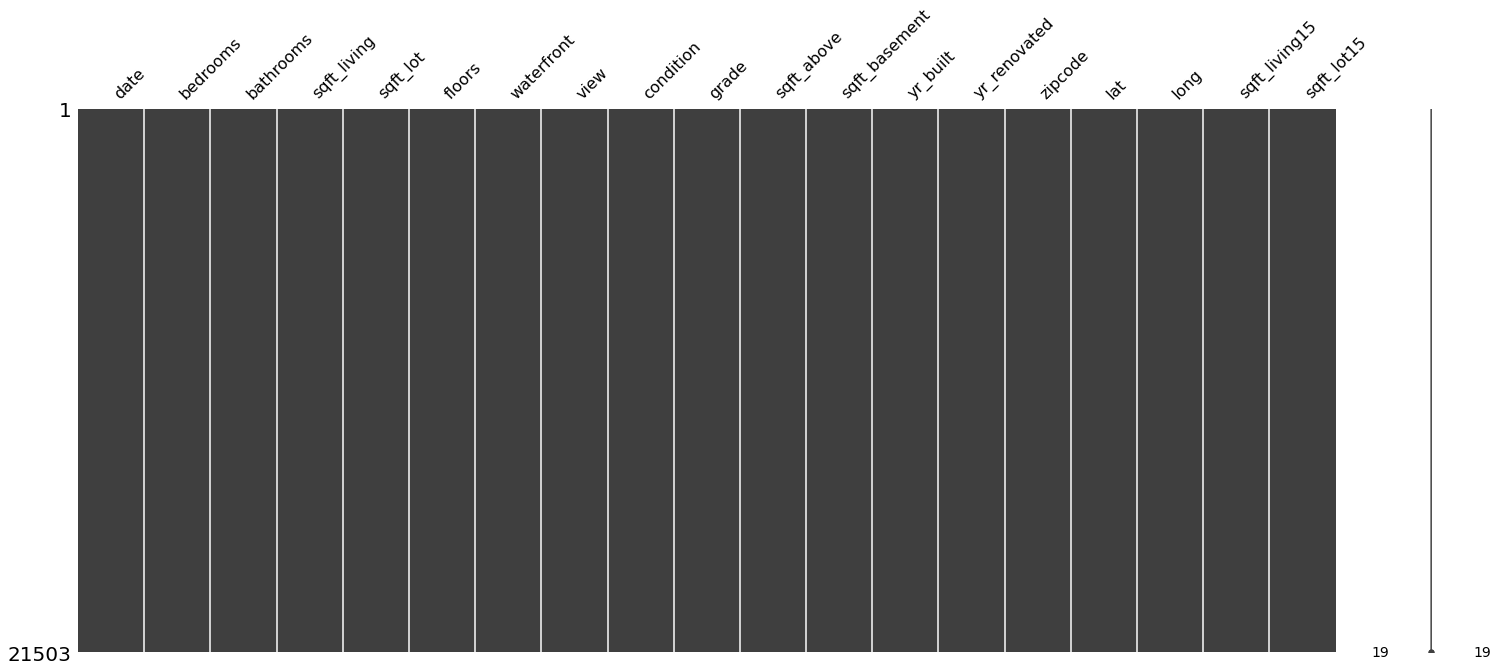

In [12]:
# data 결측값 확인
msno.matrix(data)

In [13]:
data.isnull().sum()

date             0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

=> train, test의 모든 feature가 결측값이 없는 것을 확인했다.

## 3-2. date 변환
- date 컬럼: 시간 부분은 필요 없고, day까지 학습데이터로 포함하면 카디널리티가 높아지므로,  
    적절한 카디널리티를 위해 yearmonth 까지만 데이터를 변환한다

In [14]:
# df를 전달받아 date를 앞을 6자리만 남기고, int 타입으로 변환한 뒤, df를 반환
def convert_date(df: DataFrame):
    df['date'] = df['date'].apply(lambda x: x[:6]).astype(int)
    return df

In [15]:
# data 대해 date 변환
data = convert_date(data)
# 확인
display(data.head())
# 데이터 타입 확인
data.info()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


<class 'pandas.core.frame.DataFrame'>
Int64Index: 21503 entries, 0 to 6467
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   date           21503 non-null  int64  
 1   bedrooms       21503 non-null  int64  
 2   bathrooms      21503 non-null  float64
 3   sqft_living    21503 non-null  int64  
 4   sqft_lot       21503 non-null  int64  
 5   floors         21503 non-null  float64
 6   waterfront     21503 non-null  int64  
 7   view           21503 non-null  int64  
 8   condition      21503 non-null  int64  
 9   grade          21503 non-null  int64  
 10  sqft_above     21503 non-null  int64  
 11  sqft_basement  21503 non-null  int64  
 12  yr_built       21503 non-null  int64  
 13  yr_renovated   21503 non-null  int64  
 14  zipcode        21503 non-null  int64  
 15  lat            21503 non-null  float64
 16  long           21503 non-null  float64
 17  sqft_living15  21503 non-null  int64  
 18  sqft_lo

In [16]:
data_original = data.copy()
data_original.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


## 3-3. 새로운 feature 생성, 데이터 분포 확인 및 로그변환
- 치우친 분포를 가지고 있다. -> 로그 변환으로 정규분포로 변환한다.  
- 왜 정규분포로 해야 하는가? => 회귀 문제는 연속된 값들을 예측하는 것이다. 좁은 구간에 몰려 있으면 예측을 하기 어렵기 때문에 정규분포 모양으로 변환한다.

In [17]:
# kde를 grid롤 그리는 함수 (try except로 columns 사이즈와 rows*cols 크기를 비교해서 except를 발생할 수 있게 개선해야 함)
def plot_kde_grid(data, rows, cols, figsize, columns):
    
    fix, axes = plt.subplots(rows, cols, figsize=figsize)
    count = 0
    for row in range(rows):
        for col in range(cols):
            sns.kdeplot(data=data[columns[count]], ax = axes[row][col])
            axes[row][col].set_title(columns[count], fontsize=15)
            count += 1
            if count == len(columns):
                break

In [18]:
plot_columns = data.columns.drop(['date'])
plot_columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

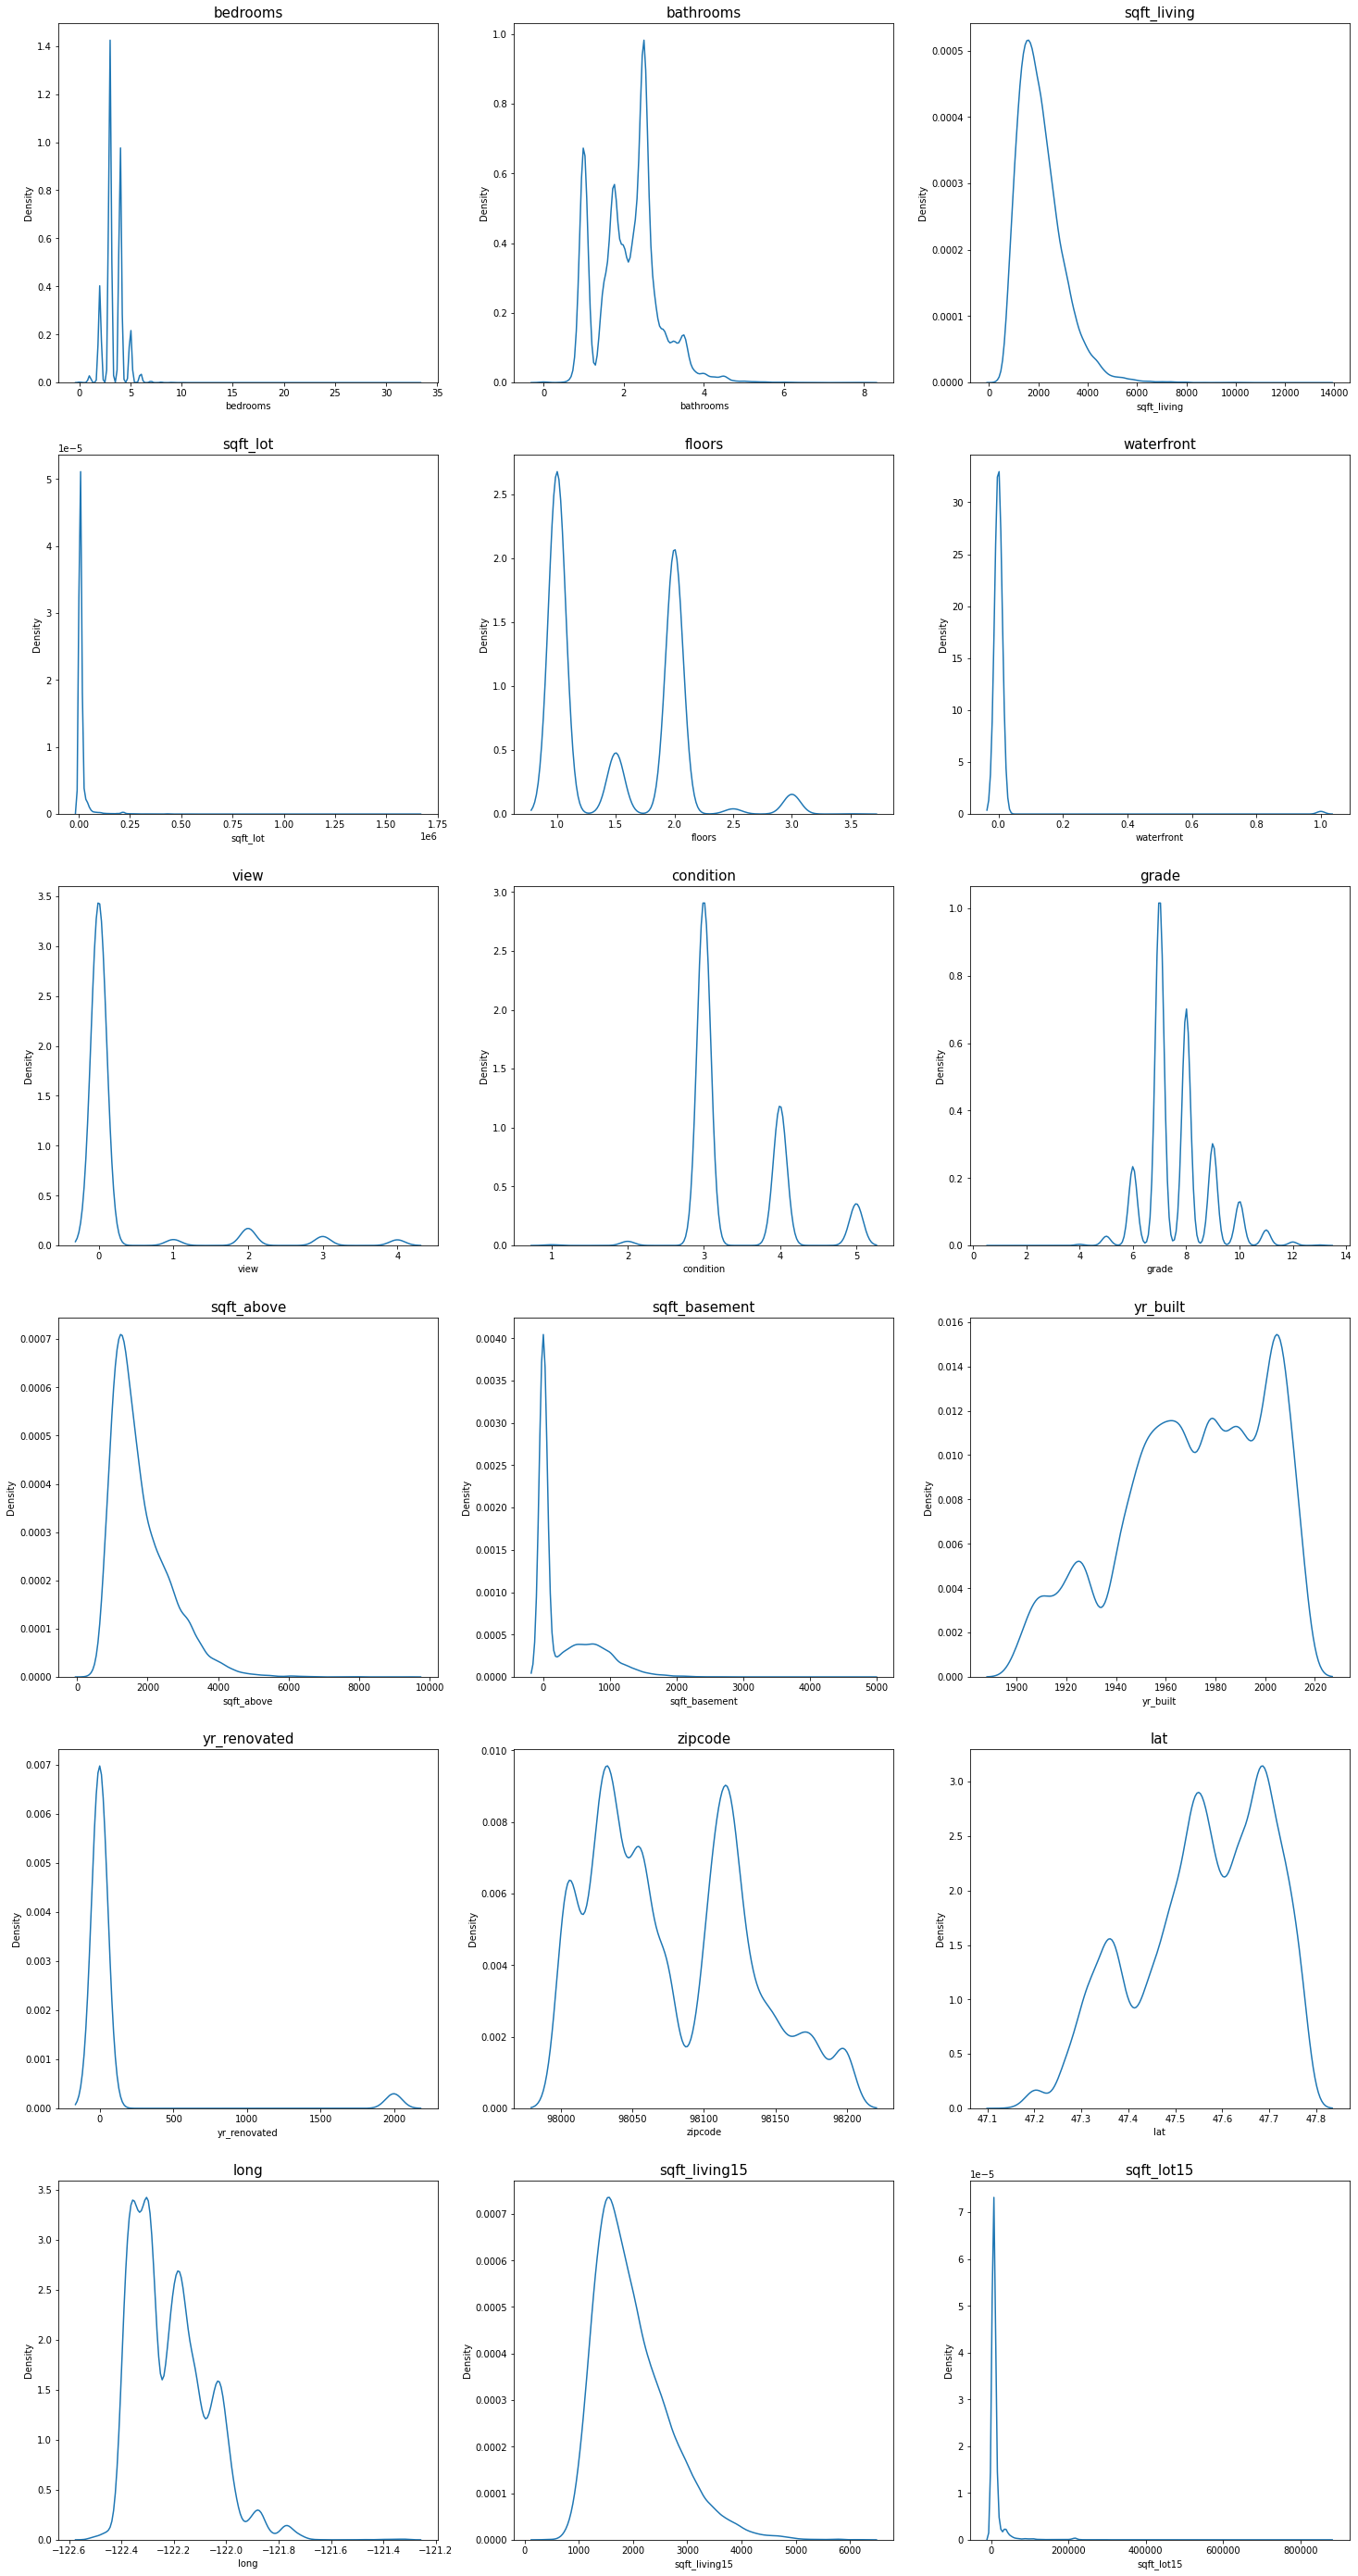

In [19]:
plot_kde_grid(data, 6, 3, (25, 50), plot_columns)

In [20]:
# 치우침 정도(skewness) 수치 확인
data.skew().sort_values(ascending=False)

sqft_lot         13.063414
waterfront       11.355434
sqft_lot15        9.509190
yr_renovated      4.539105
view              3.392064
bedrooms          1.983385
sqft_basement     1.576345
sqft_living       1.471414
sqft_above        1.446008
sqft_living15     1.106594
condition         1.036647
long              0.884048
grade             0.770530
date              0.764380
floors            0.613499
bathrooms         0.510653
zipcode           0.407406
yr_built         -0.471730
lat              -0.486830
dtype: float64

abs(skewness) > 1 인 컬럼만 log 변환을 진행한다.

In [21]:
# skew_columns 정의
skew_columns = data.columns[abs(data.skew()) > 1]
skew_columns

Index(['bedrooms', 'sqft_living', 'sqft_lot', 'waterfront', 'view',
       'condition', 'sqft_above', 'sqft_basement', 'yr_renovated',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [22]:
# 로그변환 함수를 만들어서 진행
def log_transform(df:DataFrame, skew_columns:list):
    for column in skew_columns:
        df[column] = np.log1p(df[column].values)
    
    return df

In [23]:
# 로그 변환
data = log_transform(data, skew_columns)

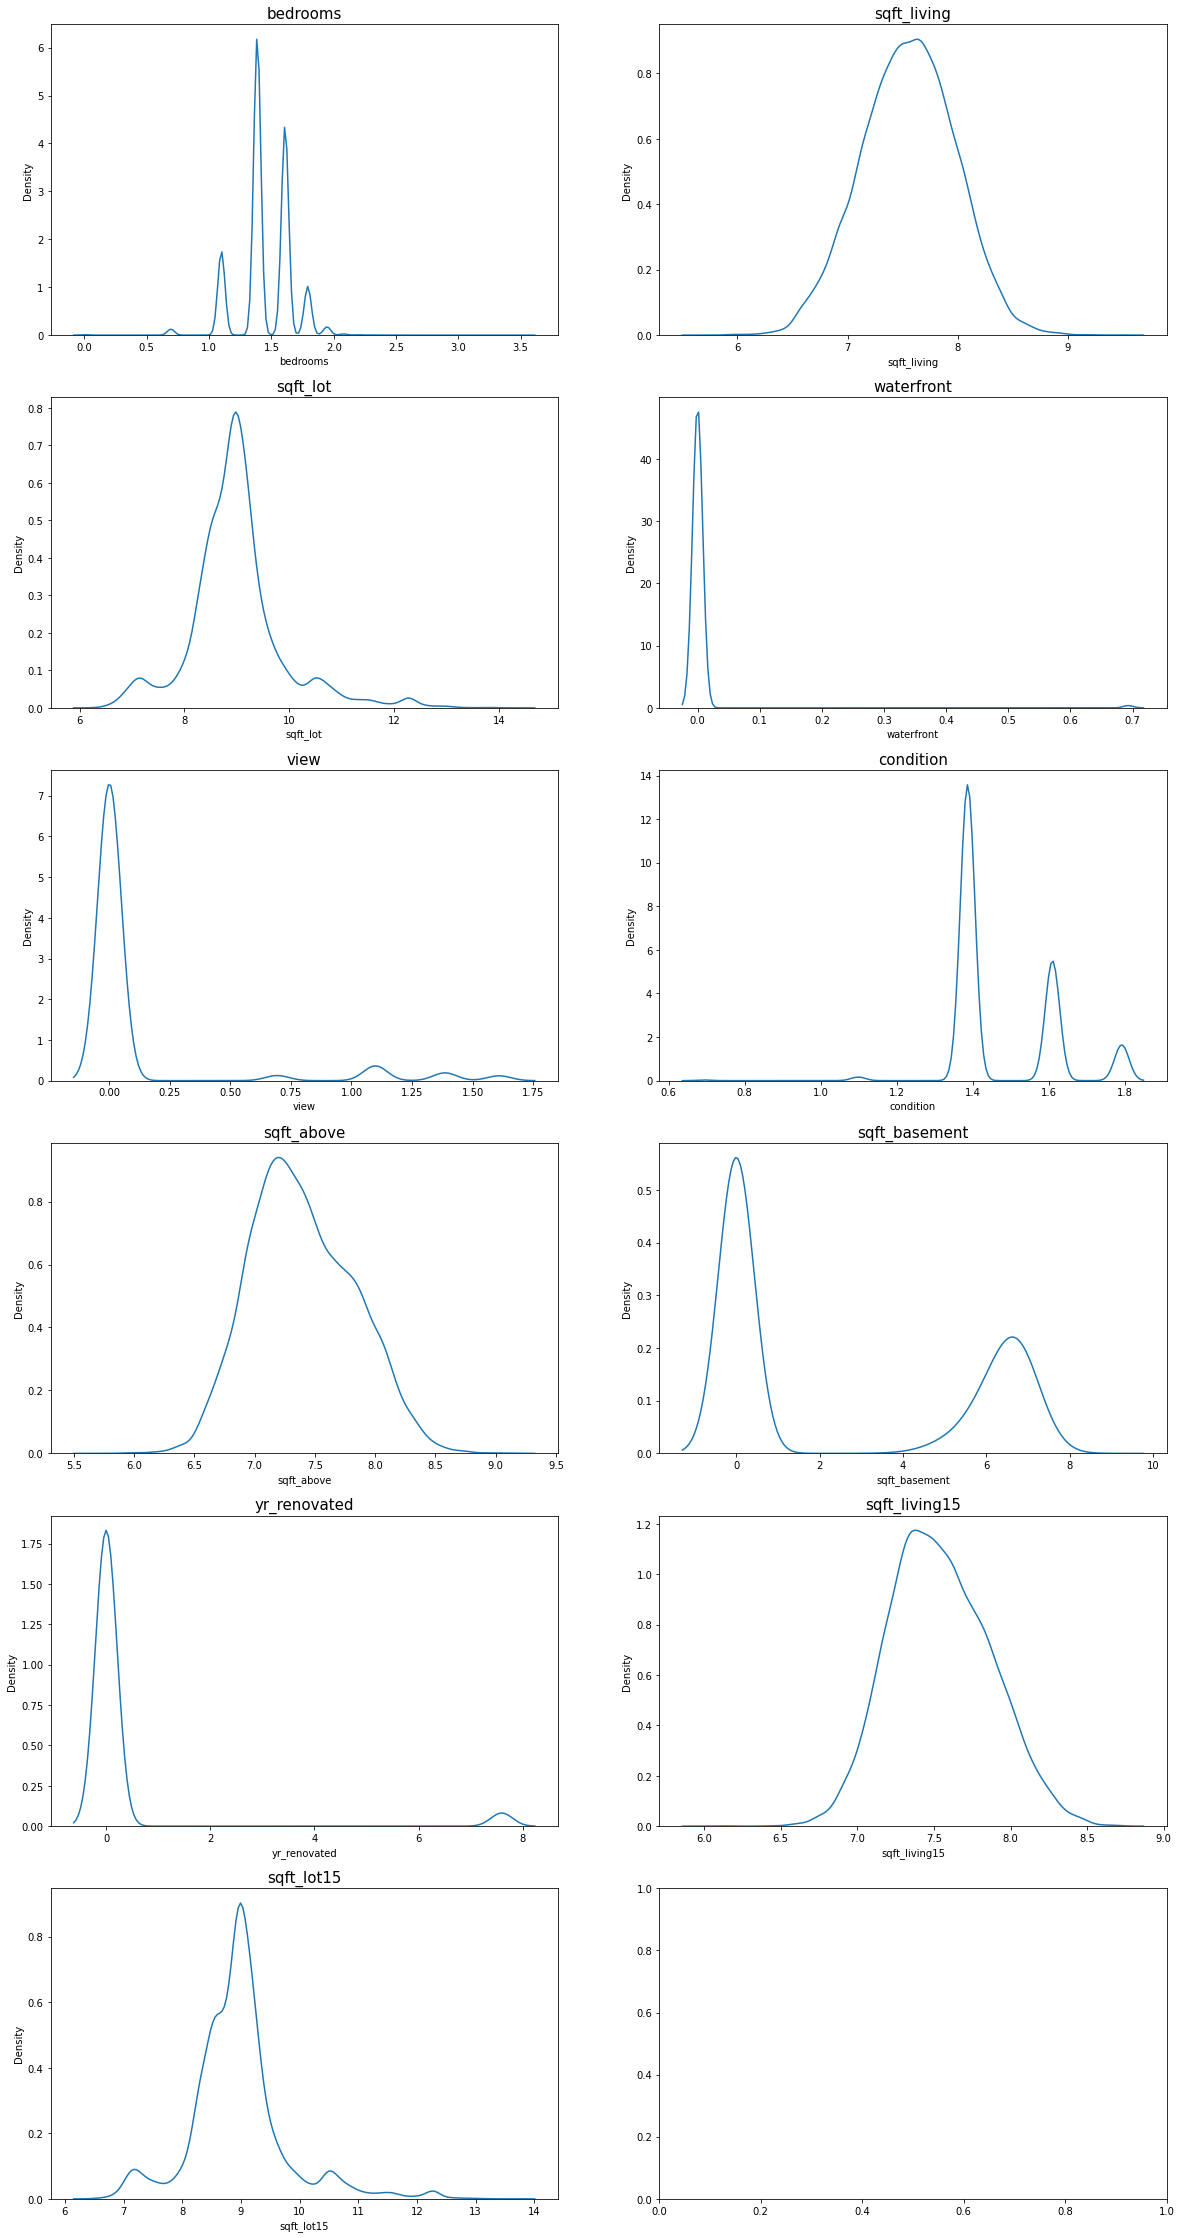

In [24]:
#  plot를 만들어서 확인
plot_kde_grid(data, 6, 2, (20,40), skew_columns)

=> skewness 절댓값이 1 초과하는 컬럼에 대해 로그 변환을 진행하였다.  
하지만 **`waterfront`, `view`, `yr_renovated`는 로그 변환을 해도 치우침 정도가 좋아지지 않았고,  
`condition`은 오히려 그래프상 치우짐 정도가 더 안 좋아졌다.**  
따라서, skew_columns을 아래와 같이 변경하고, 전처리를 다시 진행한다 
```python
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']
```

In [25]:
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15', 'sqft_living15']

In [26]:
data = log_transform(data_original, skew_columns)

In [27]:
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,1.386294,1.00,7.074117,8.639588,1.0,0,0,3,7,7.074117,0.0,1955,0,98178,47.5112,-122.257,7.201171,8.639588
1,201502,1.098612,1.00,6.647688,9.210440,1.0,0,0,3,6,6.647688,0.0,1933,0,98028,47.7379,-122.233,7.908755,8.995041
2,201502,1.386294,2.00,7.427144,8.997271,1.0,0,0,3,8,7.427144,0.0,1987,0,98074,47.6168,-122.045,7.496097,8.923191
3,201406,1.386294,2.25,7.447751,8.827615,2.0,0,0,3,7,7.447751,0.0,1995,0,98003,47.3097,-122.327,7.713785,8.827615
4,201501,1.386294,1.50,6.966967,9.181118,1.0,0,0,3,7,6.966967,0.0,1963,0,98198,47.4095,-122.315,7.409136,9.181118


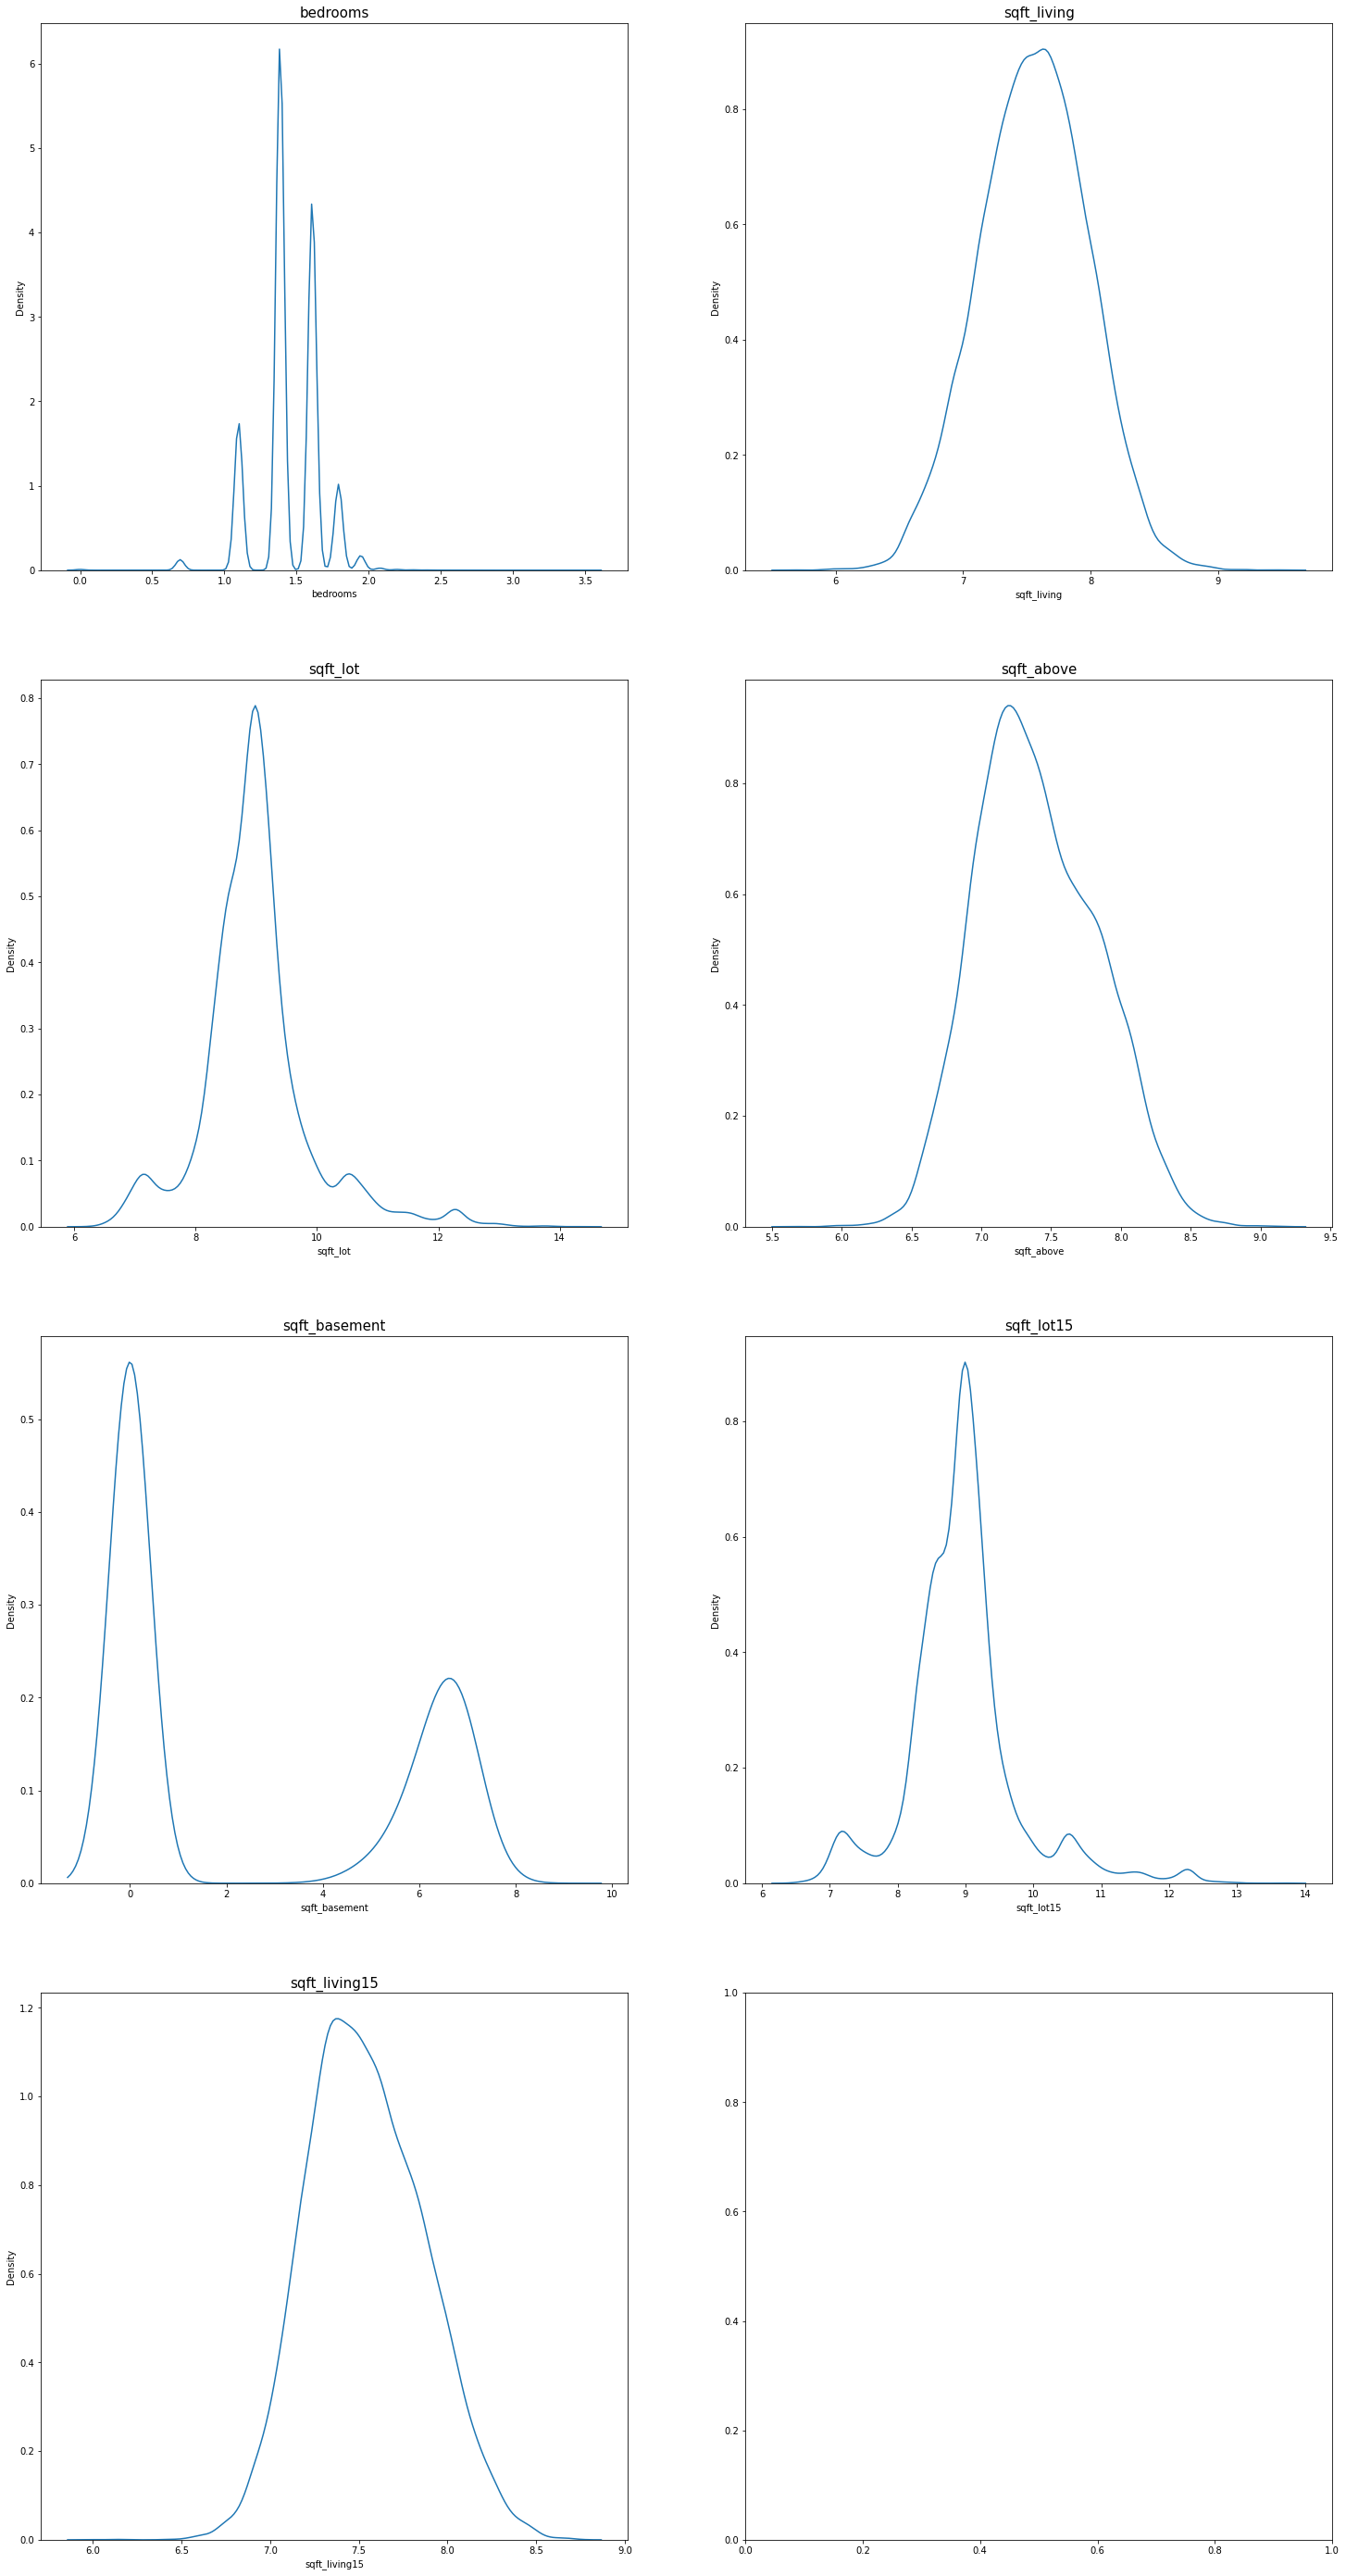

In [28]:
plot_kde_grid(data, 4, 2, (25, 50), skew_columns)

# 5. target y 탐색

y로 비대칭적이므로, 로그변환으로 정규분포에 가깝게 변환한다

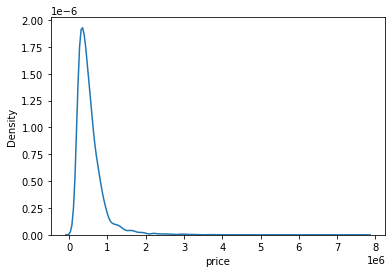

In [29]:
sns.kdeplot(y)
plt.show()

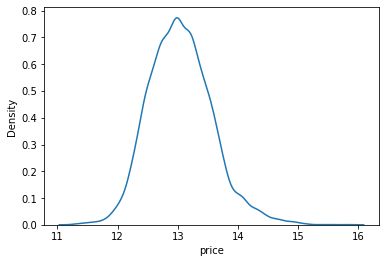

In [30]:
y = np.log1p(y)

sns.kdeplot(y)
plt.show()

data -> train, test로 분리한다

In [31]:
train = data.iloc[:train_len, :]
test = data.iloc[train_len:, :]

print(train.shape)
print(test.shape)

(15035, 19)
(6468, 19)


# 5. 모델 준비

In [32]:
# 학습 모델
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

# 데이터 train, validation 분리
from sklearn.model_selection import train_test_split
# 평가
from sklearn.metrics import mean_squared_error
# 하이퍼 파라미터 튜닝을 위한 GridSearchCV
from sklearn.model_selection import GridSearchCV

In [33]:
random_state = 2020

gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)

models = [gboost, xgboost, lightgbm, rdforest]


RMSE 평가 지표를 함수로 만들어서 사용한다. y를 로그 변환했기 때문에 expm1로 다시 지수변환으로 원래의 값으로 되돌린 후, 평가한다

In [34]:
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [35]:
def get_scores(models, train, y):
    df = {}
    for model in models:
        
        model_name = model.__class__.__name__

        X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.2, random_state=45)

        model.fit(X_train, y_train)

        y_pred = model.predict(X_test)

        df[model_name] = rmse(y_test, y_pred)
        
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
        
    return score_df

# 6. 하이퍼 파라미터 튜닝 전 성능 확인

In [36]:
# 하이퍼 파라미터 튜닝 전 성능 확인
get_scores(models, train, y)

,RMSE
RandomForestRegressor,157720.717359
GradientBoostingRegressor,154799.892896
LGBMRegressor,143521.877082
XGBRegressor,137118.344517


# 7. 하이퍼 파라미터 튜닝

In [37]:
model_params = [
    {
        "model": gboost,
        "param_grid": {
            "n_estimators": [500],
            "learning_rate": [0.1, 0.2],
            "max_depth": [ 5, 7],
        },
    },
    {
        "model": xgboost,
        "param_grid": {"learning_rate": [ 0.1, 0.2], "max_depth": [ 7, 9]},
    },
    {
        "model": lightgbm,
        "param_grid": {
            "learning_rate": [0.1, 0.2],
            "max_depth": [  7, 9],
        },
    },
    {
        "model": rdforest,
        "param_grid": {
            "n_estimators": [100, 500],
            "max_depth": [ 7, 10],
        },
    },
]


In [38]:
# GridSearchCV를 함수로 만들어 결과 확인
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, 
                                scoring='neg_mean_squared_error',    
                                cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train,y)
    params = grid_model.cv_results_['params']

    score = grid_model.cv_results_['mean_test_score']


    results = pd.DataFrame(params)
    results['score'] = score
    results['RMSLE'] = np.sqrt(-1 * results['score'])

    results = results.sort_values(by='RMSLE')
    print(f"best params: {grid_model.best_params_}")

    return results

In [45]:
# for문으로 각 모델별 최적의 파라미터를 확인
for entry in model_params:
    model = entry["model"]
    param_grid = entry["param_grid"]
    
    result = my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)
    display(result)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}


,learning_rate,max_depth,n_estimators,score,RMSLE
0,0.1,5,500,-0.026646,0.163235
1,0.1,7,500,-0.027361,0.165411
2,0.2,5,500,-0.028617,0.169166
3,0.2,7,500,-0.029685,0.172293


Fitting 5 folds for each of 4 candidates, totalling 20 fits


/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warnings.warn(
/opt/conda/lib/python3.9/site-packages/pkg_resources/__init__.py:122: PkgResourcesDeprecationWarning: 0.996-ko-0.9.2 is an invalid version and will not be supported in a future release
  warni

best params: {'learning_rate': 0.1, 'max_depth': 9}


,learning_rate,max_depth,score,RMSLE
1,0.1,9,-0.027301,0.165229
0,0.1,7,-0.027467,0.165732
2,0.2,7,-0.027690,0.166404
3,0.2,9,-0.028398,0.168518


Fitting 5 folds for each of 4 candidates, totalling 20 fits
best params: {'learning_rate': 0.1, 'max_depth': 9}


,learning_rate,max_depth,score,RMSLE
1,0.1,9,-0.027271,0.165140
3,0.2,9,-0.027278,0.165159
2,0.2,7,-0.027450,0.165680
0,0.1,7,-0.027470,0.165741


Fitting 5 folds for each of 4 candidates, totalling 20 fits
best params: {'max_depth': 10, 'n_estimators': 500}


,max_depth,n_estimators,score,RMSLE
3,10,500,-0.035237,0.187714
2,10,100,-0.035521,0.188471
1,7,500,-0.044686,0.211390
0,7,100,-0.044999,0.212130


[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=500; total time= 1.9min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=500; total time= 2.6min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=500; total time= 1.9min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=500; total time= 2.6min
[CV] END .....................learning_rate=0.1, max_depth=7; total time=  44.3s
[CV] END .....................learning_rate=0.1, max_depth=9; total time=  39.2s
[CV] END .....................learning_rate=0.2, max_depth=7; total time=  57.0s
[CV] END .....................learning_rate=0.2, max_depth=9; total time= 1.1min
[CV] END .....................learning_rate=0.1, max_depth=7; total time=   1.1s
[CV] END .....................learning_rate=0.1, max_depth=9; total time=   1.4s
[CV] END .....................learning_rate=0.2, max_depth=7; total time=   1.2s
[CV] END .....................learning_rate=0.2, max_depth=9; total time=   1.1s
[CV] END ...................

가장 좋은 파라미터로 다음과 같이 나왔다
- gboost: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 500}
- xgboost: {'learning_rate': 0.1, 'max_depth': 9}
- lightgbm: {'learning_rate': 0.1, 'max_depth': 9}
- rdforest: {'max_depth': 10, 'n_estimators': 500}

하이퍼 파라미터를 적용한 모델 생성

In [39]:
gboost_tuned = GradientBoostingRegressor(random_state=random_state, learning_rate= 0.1, max_depth= 5, n_estimators= 500)
xgboost_tuned = XGBRegressor(random_state=random_state, learning_rate=0.1, max_depth=9)
lightgbm_tuned = LGBMRegressor(random_state=random_state, learning_rate=0.1, max_depth=9)
rdforest_tuned = RandomForestRegressor(random_state=random_state, max_depth=10, n_estimators=500)

models_tuned = [gboost_tuned, xgboost_tuned, lightgbm_tuned, rdforest_tuned]

In [40]:
# 튜닝전 모델
get_scores(models, train, y)

,RMSE
RandomForestRegressor,157720.717359
GradientBoostingRegressor,154799.892896
LGBMRegressor,143521.877082
XGBRegressor,137118.344517


In [41]:
# 튜닝한 모델
get_scores(models_tuned, train, y)

,RMSE
RandomForestRegressor,157497.669411
XGBRegressor,142927.037981
LGBMRegressor,139195.562641
GradientBoostingRegressor,126167.455962


하이퍼 파라미터 튜닝한 모델이 전반적으로 성능이 향상되었다.  
여러 모델 중, 가장 좋은 성능을 보이는 `GradientBoostingRegressor`로 kaggle을 제출해본다

In [86]:
def save_submission(model, train, y, test,test_id,  model_name, rmse):
    
    model.fit(train, y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    
    submission = test_id.to_frame()
    submission['price'] = prediction
    submission_csv_path = '{}/submission_{}_RMSE_{}.csv'.format(data_dir, model_name, rmse)
    
    submission.to_csv(submission_csv_path, index=False)

In [46]:
save_submission(gboost_tuned, train, y, test,test_id, "gboost", rmse="126167.455962",  )

[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=100; total time=  17.9s
[CV] END ...learning_rate=0.1, max_depth=5, n_estimators=500; total time= 1.5min
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=100; total time=  25.1s
[CV] END ...learning_rate=0.1, max_depth=7, n_estimators=500; total time= 2.1min
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=100; total time=  17.7s
[CV] END ...learning_rate=0.2, max_depth=5, n_estimators=500; total time= 1.5min
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=100; total time=  25.0s
[CV] END ...learning_rate=0.2, max_depth=7, n_estimators=500; total time= 2.0min
[CV] END .....................learning_rate=0.1, max_depth=7; total time=  54.7s
[CV] END .....................learning_rate=0.1, max_depth=9; total time=  32.7s
[CV] END .....................learning_rate=0.2, max_depth=7; total time=  52.4s
[CV] END .....................learning_rate=0.2, max_depth=9; total time= 1.3min
[CV] END ...................

# month feature 생성

In [101]:
display(train_original.head())
display(test_original.head())

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,15035,20141209T000000,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
1,15036,20141209T000000,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
2,15037,20140512T000000,4,4.50,5420,101930,1.0,0,0,3,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
3,15038,20150415T000000,3,1.00,1780,7470,1.0,0,0,3,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
4,15039,20150312T000000,3,2.50,1890,6560,2.0,0,0,3,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


In [102]:
def preprocessing(train_original, test_original):
    train = train_original.copy()
    test = test_original.copy()
    
    # 학습을 위한 target 값 분리
    y = train['price']
    del train['price']
    # train 데이터 갯수 저장
    train_len = len(train)
    print(train_len)

    # 데이터 합쳐져 탐색
    data = pd.concat((train, test), axis=0)

    print(len(data))
    test_id = data['id'][train_len:]
    del data['id']
    data = convert_date(data)
    data = log_transform(data_original, skew_columns)
    y = np.log1p(y)
    
    train = data.iloc[:train_len, :]
    test = data.iloc[train_len:, :]

    print(train.shape)
    print(test.shape)
    return train, test, y

In [115]:
train, test, y = preprocessing(train_original, test_original)

15035
21503
(15035, 19)
(6468, 19)


In [116]:
# month feature 생성
train['month'] = train['date'].astype('str').str[-2:].astype(int)

/tmp/ipykernel_687/606459775.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['month'] = train['date'].astype('str').str[-2:].astype(int)


In [119]:
test['month'] = test['date'].astype('str').str[-2:].astype(int)

/tmp/ipykernel_687/1409442237.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['month'] = test['date'].astype('str').str[-2:].astype(int)


<AxesSubplot:xlabel='month', ylabel='count'>

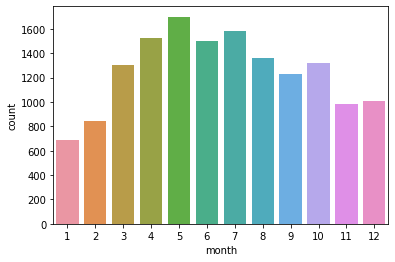

In [120]:
sns.countplot(data=train, x='month')

In [121]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,month
0,201410,0.287938,1.00,0.369001,0.375428,1.0,0,0,3,7,0.369001,0.0,1955,0,98178,47.5112,-122.257,0.369597,0.375428,10
1,201502,0.271186,1.00,0.366881,0.377368,1.0,0,0,3,6,0.366881,0.0,1933,0,98028,47.7379,-122.233,0.372657,0.376657,2
2,201502,0.287938,2.00,0.370620,0.376664,1.0,0,0,3,8,0.370620,0.0,1987,0,98074,47.6168,-122.045,0.370923,0.376414,2
3,201406,0.287938,2.25,0.370711,0.376087,2.0,0,0,3,7,0.370711,0.0,1995,0,98003,47.3097,-122.327,0.371855,0.376087,6
4,201501,0.287938,1.50,0.368486,0.377272,1.0,0,0,3,7,0.368486,0.0,1963,0,98198,47.4095,-122.315,0.370540,0.377272,1


In [123]:
gboost_tuned = GradientBoostingRegressor(random_state=random_state, learning_rate= 0.1, max_depth= 5, n_estimators= 500)
xgboost_tuned = XGBRegressor(random_state=random_state, learning_rate=0.1, max_depth=9)
lightgbm_tuned = LGBMRegressor(random_state=random_state, learning_rate=0.1, max_depth=9)
rdforest_tuned = RandomForestRegressor(random_state=random_state, max_depth=10, n_estimators=500)

models_tuned = [gboost_tuned]

In [124]:
get_scores(models_tuned, train, y)

,RMSE
GradientBoostingRegressor,122113.272252


=> month를 추가해서 성능이 조금 향상되었다

In [125]:
save_submission(gboost_tuned, train, y, test,test_id, "gboost", rmse="122113.272252",  )

# KMeans를 사용한 lat, long 피처 엔지니어링

In [158]:
from sklearn.cluster import KMeans

coords = train[["lat", "long"]]
kmeans = KMeans(n_clusters=20, random_state=42)
train["location_cluster"] = kmeans.fit_predict(coords)


/tmp/ipykernel_687/1340296258.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["location_cluster"] = kmeans.fit_predict(coords)


In [159]:
test["location_cluster"] = kmeans.predict(test[["lat", "long"]])

/tmp/ipykernel_687/2620999097.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["location_cluster"] = kmeans.predict(test[["lat", "long"]])


In [160]:
train.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zipcode_freq,location_cluster
0,201410,0.185159,1.00,0.216308,0.218553,1.0,0,0,3,7,...,0.0,1955,0,98178,47.5112,-122.257,0.216517,0.218553,192,16
1,201502,0.177981,1.00,0.215561,0.219225,1.0,0,0,3,6,...,0.0,1933,0,98028,47.7379,-122.233,0.217589,0.218979,201,13
2,201502,0.185159,2.00,0.216876,0.218982,1.0,0,0,3,8,...,0.0,1987,0,98074,47.6168,-122.045,0.216983,0.218895,295,5
3,201406,0.185159,2.25,0.216908,0.218782,2.0,0,0,3,7,...,0.0,1995,0,98003,47.3097,-122.327,0.217309,0.218782,185,1
4,201501,0.185159,1.50,0.216127,0.219192,1.0,0,0,3,7,...,0.0,1963,0,98198,47.4095,-122.315,0.216848,0.219192,198,10


In [161]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zipcode_freq,location_cluster
0,201412,0.185159,2.25,0.217508,0.218853,2.0,0,0,3,7,...,0.214261,1951,1991,98125,47.7210,-122.319,0.216886,0.218916,294,3
1,201412,0.189321,3.00,0.217112,0.218401,1.0,0,0,5,7,...,0.215862,1965,0,98136,47.5208,-122.393,0.216541,0.218401,179,15
2,201405,0.189321,4.50,0.218502,0.221423,1.0,0,0,3,11,...,0.216730,2001,0,98053,47.6561,-122.005,0.218338,0.221423,284,12
3,201504,0.185159,1.00,0.216965,0.218890,1.0,0,0,3,7,...,0.215462,1960,0,98146,47.5123,-122.337,0.216965,0.218986,190,15
4,201503,0.185159,2.50,0.217057,0.218735,2.0,0,0,3,7,...,0.000000,2003,0,98038,47.3684,-122.031,0.217404,0.218906,420,7


In [163]:
gboost_tuned = GradientBoostingRegressor(random_state=random_state, learning_rate= 0.1, max_depth= 5, n_estimators= 500)
xgboost_tuned = XGBRegressor(random_state=random_state, learning_rate=0.1, max_depth=9)
lightgbm_tuned = LGBMRegressor(random_state=random_state, learning_rate=0.1, max_depth=9)
rdforest_tuned = RandomForestRegressor(random_state=random_state, max_depth=10, n_estimators=500)

models_tuned = [gboost_tuned]
get_scores(models_tuned, train, y)

,RMSE
GradientBoostingRegressor,125275.150687


In [164]:
save_submission(gboost_tuned, train, y, test,test_id, "gboost", rmse="125275.150687",  )

# zipcode 피처 엔지니어링

In [167]:
train, test, y = preprocessing(train_original, test_original)

15035
21503
(15035, 19)
(6468, 19)


In [168]:
train['price'] = y

/tmp/ipykernel_687/180752955.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['price'] = y


In [169]:
zipcode_price = train.groupby("zipcode")["price"].mean()
train["zipcode_price"] = train["zipcode"].map(zipcode_price)

/tmp/ipykernel_687/3991680786.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train["zipcode_price"] = train["zipcode"].map(zipcode_price)


In [170]:
train.drop(columns=['price'],inplace=True)
train.head()

/opt/conda/lib/python3.9/site-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zipcode_price
0,201410,0.169877,1.00,0.195820,0.197664,1.0,0,0,3,7,0.195820,0.0,1955,0,98178,47.5112,-122.257,0.195992,0.197664,12.560076
1,201502,0.163802,1.00,0.195206,0.198215,1.0,0,0,3,6,0.195206,0.0,1933,0,98028,47.7379,-122.233,0.196873,0.198014,12.987830
2,201502,0.169877,2.00,0.196287,0.198016,1.0,0,0,3,8,0.196287,0.0,1987,0,98074,47.6168,-122.045,0.196375,0.197945,13.393930
3,201406,0.169877,2.25,0.196313,0.197852,2.0,0,0,3,7,0.196313,0.0,1995,0,98003,47.3097,-122.327,0.196642,0.197852,12.521928
4,201501,0.169877,1.50,0.195671,0.198188,1.0,0,0,3,7,0.195671,0.0,1963,0,98198,47.4095,-122.315,0.196264,0.198188,12.538306


In [171]:
test["zipcode_price"] = test["zipcode"].map(zipcode_price)

/tmp/ipykernel_687/4176626096.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test["zipcode_price"] = test["zipcode"].map(zipcode_price)


In [172]:
test.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,zipcode_price
0,201412,0.169877,2.25,0.196807,0.197911,2.0,0,0,3,7,0.196605,0.194136,1951,1991,98125,47.7210,-122.319,0.196295,0.197962,12.992517
1,201412,0.173382,3.00,0.196481,0.197539,1.0,0,0,5,7,0.195658,0.195453,1965,0,98136,47.5208,-122.393,0.196012,0.197539,13.171014
2,201405,0.173382,4.50,0.197622,0.200016,1.0,0,0,3,11,0.197273,0.196167,2001,0,98053,47.6561,-122.005,0.197488,0.200016,13.361117
3,201504,0.169877,1.00,0.196360,0.197941,1.0,0,0,3,7,0.195658,0.195125,1960,0,98146,47.5123,-122.337,0.196360,0.198020,12.661821
4,201503,0.169877,2.50,0.196436,0.197814,2.0,0,0,3,7,0.196436,0.000000,2003,0,98038,47.3684,-122.031,0.196721,0.197953,12.756031


In [173]:
gboost_tuned = GradientBoostingRegressor(random_state=random_state, learning_rate= 0.1, max_depth= 5, n_estimators= 500)
xgboost_tuned = XGBRegressor(random_state=random_state, learning_rate=0.1, max_depth=9)
lightgbm_tuned = LGBMRegressor(random_state=random_state, learning_rate=0.1, max_depth=9)
rdforest_tuned = RandomForestRegressor(random_state=random_state, max_depth=10, n_estimators=500)

models_tuned = [gboost_tuned]

In [174]:
get_scores(models_tuned, train, y)

,RMSE
GradientBoostingRegressor,125796.786001


In [175]:
save_submission(gboost_tuned, train, y, test,test_id, "gboost", rmse="125796.786001",  )

In [176]:
# random_state = 45
random_state

45

![109991.98217](109991.98217.png)

# 회고
- feature engineering을 여러 기법으로 다양하게 시도해봐야 한다는 것을 알게되었다.
- validation으로 테스트한 결과와 kaggle 제출 결과과 상당히 다르다는 것을 알게되었다.
- model의 random_state도 영향을 준다는 것을 알게되었다.